In [370]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

In [371]:
def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    print ("Accuracy on training set:")
    print (clf.score(X_train, y_train))
    print ("Accuracy on testing set:")
    print (clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    print ("Classification Report:")
    print (classification_report(y_test, y_pred))
    print ("Confusion Matrix:")
    print (confusion_matrix(y_test, y_pred))

In [372]:
import pickle
with open('./data/cleaned_df.pickle', 'rb') as file:
    df = pickle.load(file)
    

## Preview the class imbalance

In [373]:
# Count the number of fraudulent/infraudulent purchases
df['default_next_month'].value_counts(normalize=True)

0    0.778594
1    0.221406
Name: default_next_month, dtype: float64

## Define the predictor and target variables

In [374]:
# Your code here
y = df['default_next_month']
#X = df.drop(columns=['default_next_month', 'Others', 'Other', 'Univ', 'Male', 'Female', 'Married', 'Single'], axis=1)
X = df.drop(columns=['default_next_month'], axis=1)
SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=SEED)

In [375]:
df.head()

age  pstatus_2005_09  pstatus_2005_08  pstatus_2005_07  pstatus_2005_06  \
1   24                1                1               -1               -1   
2   26               -1                1                0                0   
3   34                0                0                0                0   
4   37                0                0                0                0   
5   57               -1                0               -1                0   

   pstatus_2005_05  pstatus_2005_04  Male  Female  Married  ...  Other  \
1               -1               -1     0       1        1  ...      0   
2                0                1     0       1        0  ...      0   
3                0                0     0       1        0  ...      0   
4                0                0     0       1        1  ...      0   
5                0                0     1       0        1  ...      0   

   default_next_month  avg_payment  successive_payments  cred_use_2005_09  \
1                   1     0.600000                    4          0.195650   
2                   1     0.169620                    3          0.022350   
3                   0     0.115141                    6          0.324878   
4                   0     0.036396                    6          0.939800   
5                   0     1.246958                    6          0.172340   

   cred_use_2005_08  cred_use_2005_07  cred_use_2005_06  cred_use_2005_05  \
1          0.155100          0.034450          0.000000          0.000000   
2          0.014375          0.022350          0.027267          0.028792   
3          0.155856          0.150656          0.159233          0.166089   
4          0.964660          0.985820          0.566280          0.579180   
5          0.113400          0.716700          0.418800          0.382920   

   cred_use_2005_04  
1          0.000000  
2          0.027175  
3          0.172767  
4          0.590940  
5          0.382620  

[5 rows x 25 columns]

Find the class imbalance in the training and test sets: 

In [376]:
# Training set
print(y_train.value_counts(normalize=True))
print('\n')
# Test set
print(y_test.value_counts(normalize=True))

0    0.778928
1    0.221072
Name: default_next_month, dtype: float64


0    0.778093
1    0.221907
Name: default_next_month, dtype: float64


## Train a classifier

In [377]:

# Train the classifier using training data 
tree =  DecisionTreeClassifier(criterion='entropy', class_weight='balanced')
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy')

In [378]:
import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [379]:
# Create DOT data
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=X_train.columns,  
                           class_names=np.unique(y_train).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.222285 to fit



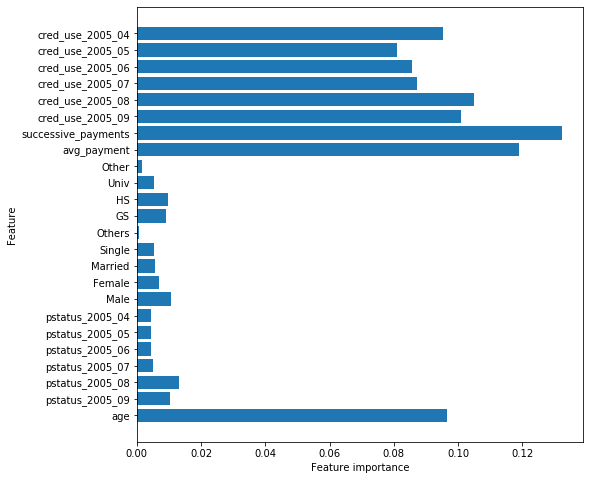

In [365]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree)

In [366]:
# Test set predictions
pred = tree.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[7602 1718]
 [1601 1057]]
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      9320
           1       0.38      0.40      0.39      2658

    accuracy                           0.72     11978
   macro avg       0.60      0.61      0.60     11978
weighted avg       0.73      0.72      0.73     11978



In [367]:
# Previous original class distribution
print(y_train.value_counts()) 



# Create the samplers
rus = RandomOverSampler(random_state=3)
#rus = RandomUnderSampler(random_state=3)

# Fit SMOTE to training data
#X_train_resampled, y_train_resampled = ADASYN().fit_sample(X_train, y_train) 
X_train_resampled, y_train_resampled = rus.fit_sample(X_train, y_train)

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts())

0    13995
1     3972
Name: default_next_month, dtype: int64


1    13995
0    13995
dtype: int64


C:\Users\Neel\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [368]:

tree = RandomForestClassifier(bootstrap=True, class_weight="balanced", criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=26, n_jobs=1,
            oob_score=True, random_state=SEED, verbose=0, warm_start=False)

tree.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, max_leaf_nodes=20, min_samples_leaf=100,
                       n_estimators=26, n_jobs=1, oob_score=True,
                       random_state=1)

In [369]:
# Test set predictions
pred = tree.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[7120 2200]
 [ 968 1690]]
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      9320
           1       0.43      0.64      0.52      2658

    accuracy                           0.74     11978
   macro avg       0.66      0.70      0.67     11978
weighted avg       0.78      0.74      0.75     11978

